In [1]:
import pandas as pd
import numpy as np

train_combined = pd.read_csv('train_combined.csv')
test_combined = pd.read_csv('test_combined.csv')

In [2]:
# select numeric columns
numeric_cols = train_combined.select_dtypes(include='number')

# replace infinite values with NaN (can cause issues in describe)
numeric_cols = numeric_cols.replace([np.inf, -np.inf], np.nan)

# drop columns that are all NaN
numeric_cols = numeric_cols.dropna(axis=1, how='all')

# drop columns with only one unique non-NaN value
valid_cols = [col for col in numeric_cols.columns if numeric_cols[col].nunique(dropna=True) > 1]

# safely describe the cleaned numeric data
train_summary = numeric_cols[valid_cols].describe().transpose()

# round numerical stats to 2 decimal places
train_summary = train_summary.round(2)

# drop 'count' if you don’t want it
if 'count' in train_summary.columns:
    train_summary = train_summary.drop(columns='count')

# style the summary (for Jupyter only)
train_summary.style.set_caption("Summary Statistics of Train Dataset").set_table_styles(
    [{'selector': 'caption', 'props': [('font-size', '14px'), ('font-weight', 'bold')]}]
)

,mean,std,min,25%,50%,75%,max
InscClaimAmtReimbursed,979.440000,3766.390000,0.000000,40.000000,80.000000,300.000000,125000.000000
DeductibleAmtPaid,78.420000,274.020000,0.000000,0.000000,0.000000,0.000000,1068.000000
Gender,1.580000,0.490000,1.000000,1.000000,2.000000,2.000000,2.000000
Race,1.260000,0.720000,1.000000,1.000000,1.000000,1.000000,5.000000
State,25.450000,15.190000,1.000000,11.000000,24.000000,38.000000,54.000000
County,378.580000,265.230000,0.000000,150.000000,350.000000,570.000000,999.000000
NoOfMonths_PartACov,11.930000,0.890000,0.000000,12.000000,12.000000,12.000000,12.000000
NoOfMonths_PartBCov,11.940000,0.790000,0.000000,12.000000,12.000000,12.000000,12.000000
ChronicCond_Alzheimer,1.600000,0.490000,1.000000,1.000000,2.000000,2.000000,2.000000
ChronicCond_Heartfailure,1.410000,0.490000,1.000000,1.000000,1.000000,2.000000,2.000000


In [3]:
# columns where all values are NaN
all_nan_cols = train_combined.columns[train_combined.isna().all()].tolist()

print("Columns with all NaN values:")
print(all_nan_cols)

Columns with all NaN values:
[]


In [4]:
# columns with only one unique non-null value
one_unique_cols = [col for col in train_combined.columns if train_combined[col].nunique(dropna=True) == 1]

print("Columns with one unique non-null value:")
print(one_unique_cols)

Columns with one unique non-null value:
['IsFraud']


In [5]:
train_combined['IsFraud'].value_counts(dropna=False)

IsFraud
0    557312
Name: count, dtype: int64

In [6]:
# drop to avoid redundancy
train_combined.drop(columns=['IsFraud'], inplace=True)

In [7]:
# Check if 'PotentialFraud' exists and has both classes
print(train_combined['PotentialFraud'].value_counts())

PotentialFraud
No     345024
Yes    212288
Name: count, dtype: int64


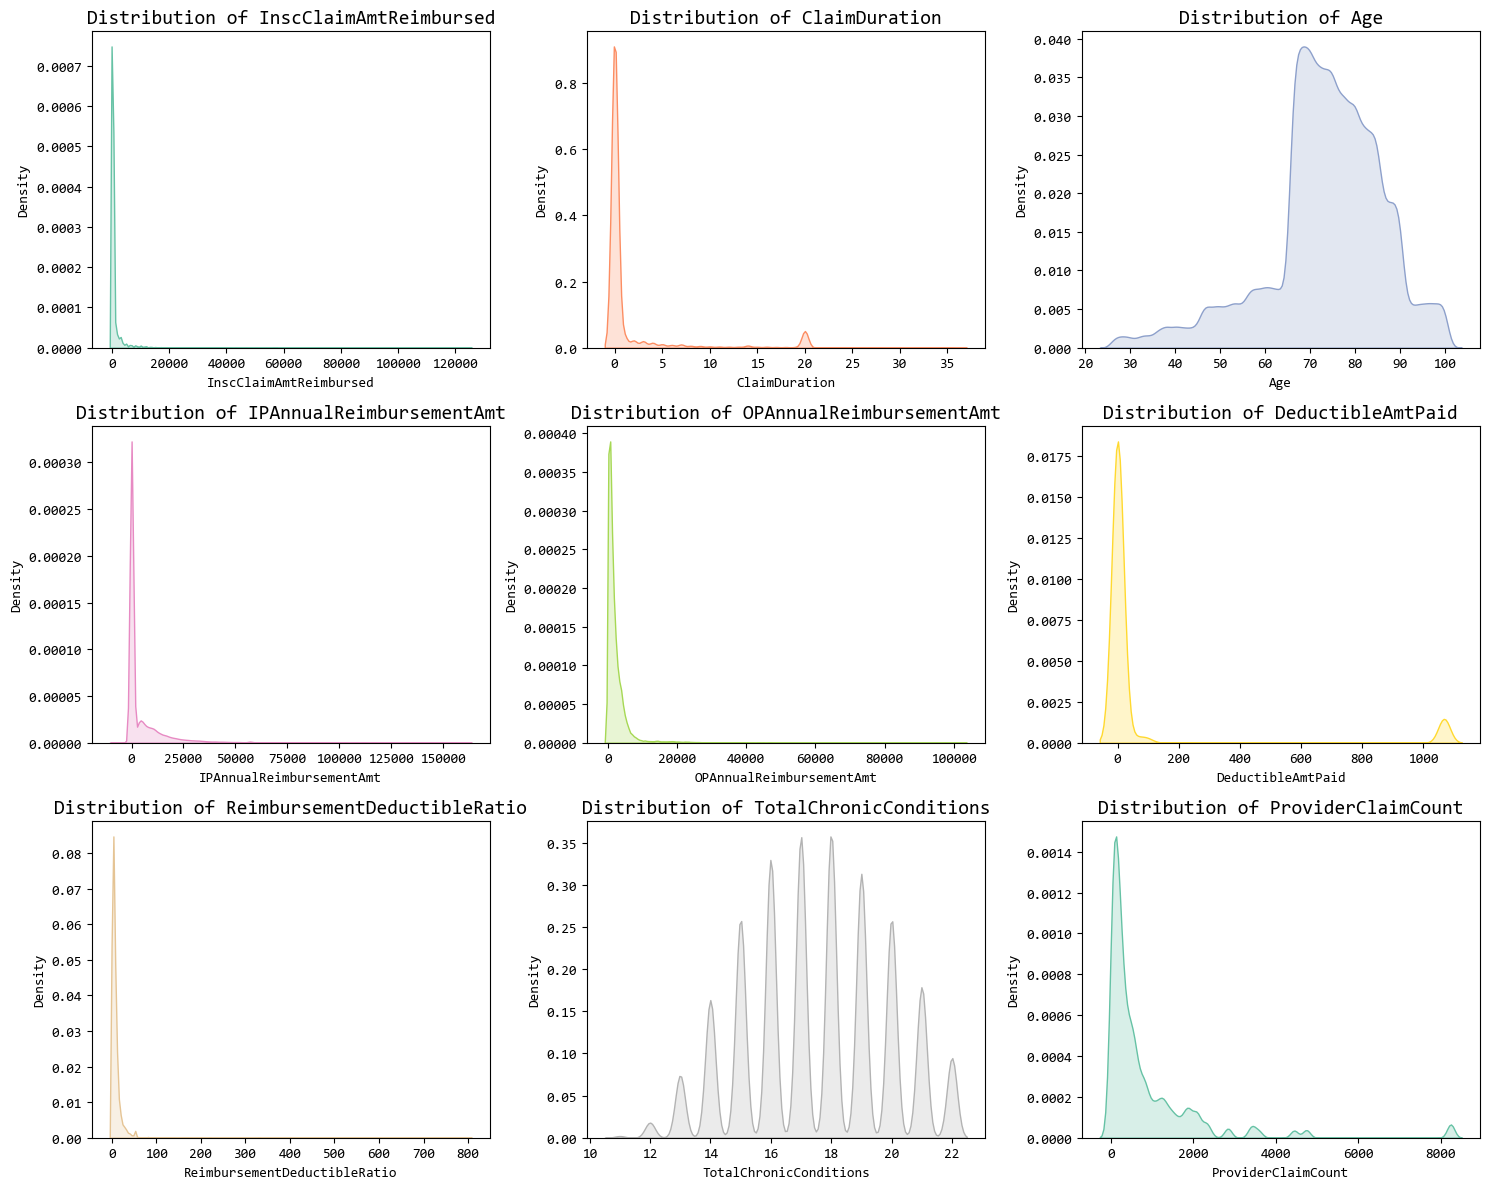

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

def visualize_numerical_distributions(df, columns):
    # set up the plot
    plt.figure(figsize=(15, 12))
    
   
    colors = sns.color_palette("Set2", len(columns))
    
    for i, col in enumerate(columns, 1):
        plt.subplot(3, 3, i)  
        sns.kdeplot(df[col], color=colors[i-1], fill=True) 
        plt.title(f'Distribution of {col}', fontsize=14, fontname='Consolas')  
        plt.xlabel(col, fontsize=10, fontname='Consolas')  
        plt.ylabel('Density', fontsize=10, fontname='Consolas')  
        plt.tick_params(axis='both', which='major', labelsize=10) 
        plt.xticks(fontsize=10, fontname='Consolas')  
        plt.yticks(fontsize=10, fontname='Consolas')  
    
    plt.tight_layout()
    plt.show()

# numerical columns to visualize
important_numerical_columns = [
    'InscClaimAmtReimbursed', 'ClaimDuration', 'Age', 
    'IPAnnualReimbursementAmt', 'OPAnnualReimbursementAmt', 
    'DeductibleAmtPaid', 'ReimbursementDeductibleRatio', 
    'TotalChronicConditions', 'ProviderClaimCount'
]

# Call the function
visualize_numerical_distributions(train_combined, important_numerical_columns)

In [9]:
# Select only numerical columns
numerical_columns = train_combined.select_dtypes(include=['number']).columns

# Calculate correlation matrix for numerical columns only
corr_matrix = train_combined[numerical_columns].corr()

# Transform the correlation matrix into a long format for easier inspection
corr_table = corr_matrix.unstack().reset_index()
corr_table.columns = ['Variable1', 'Variable2', 'Correlation']

# Filter out self-correlations (where variable is compared with itself)
corr_table = corr_table[corr_table['Variable1'] != corr_table['Variable2']]

# Filter for correlations with an absolute value of 0.5 or higher
corr_table = corr_table[abs(corr_table['Correlation']) >= 0.5]

# Sort the table by absolute correlation values for easy inspection
corr_table['AbsCorrelation'] = corr_table['Correlation'].abs()
corr_table = corr_table.sort_values(by='AbsCorrelation', ascending=False)

# Display the table without the absolute correlation column
corr_table.drop(columns='AbsCorrelation', inplace=True)

# Show the filtered correlations
corr_table

,Variable1,Variable2,Correlation
28,InscClaimAmtReimbursed,ReimbursementPerCondition,0.991692
812,ReimbursementPerCondition,InscClaimAmtReimbursed,0.991692
631,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt,0.837666
659,OPAnnualDeductibleAmt,OPAnnualReimbursementAmt,0.837666
1,InscClaimAmtReimbursed,DeductibleAmtPaid,0.665488
29,DeductibleAmtPaid,InscClaimAmtReimbursed,0.665488
813,ReimbursementPerCondition,DeductibleAmtPaid,0.661287
57,DeductibleAmtPaid,ReimbursementPerCondition,0.661287
571,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,0.643139
599,IPAnnualDeductibleAmt,IPAnnualReimbursementAmt,0.643139


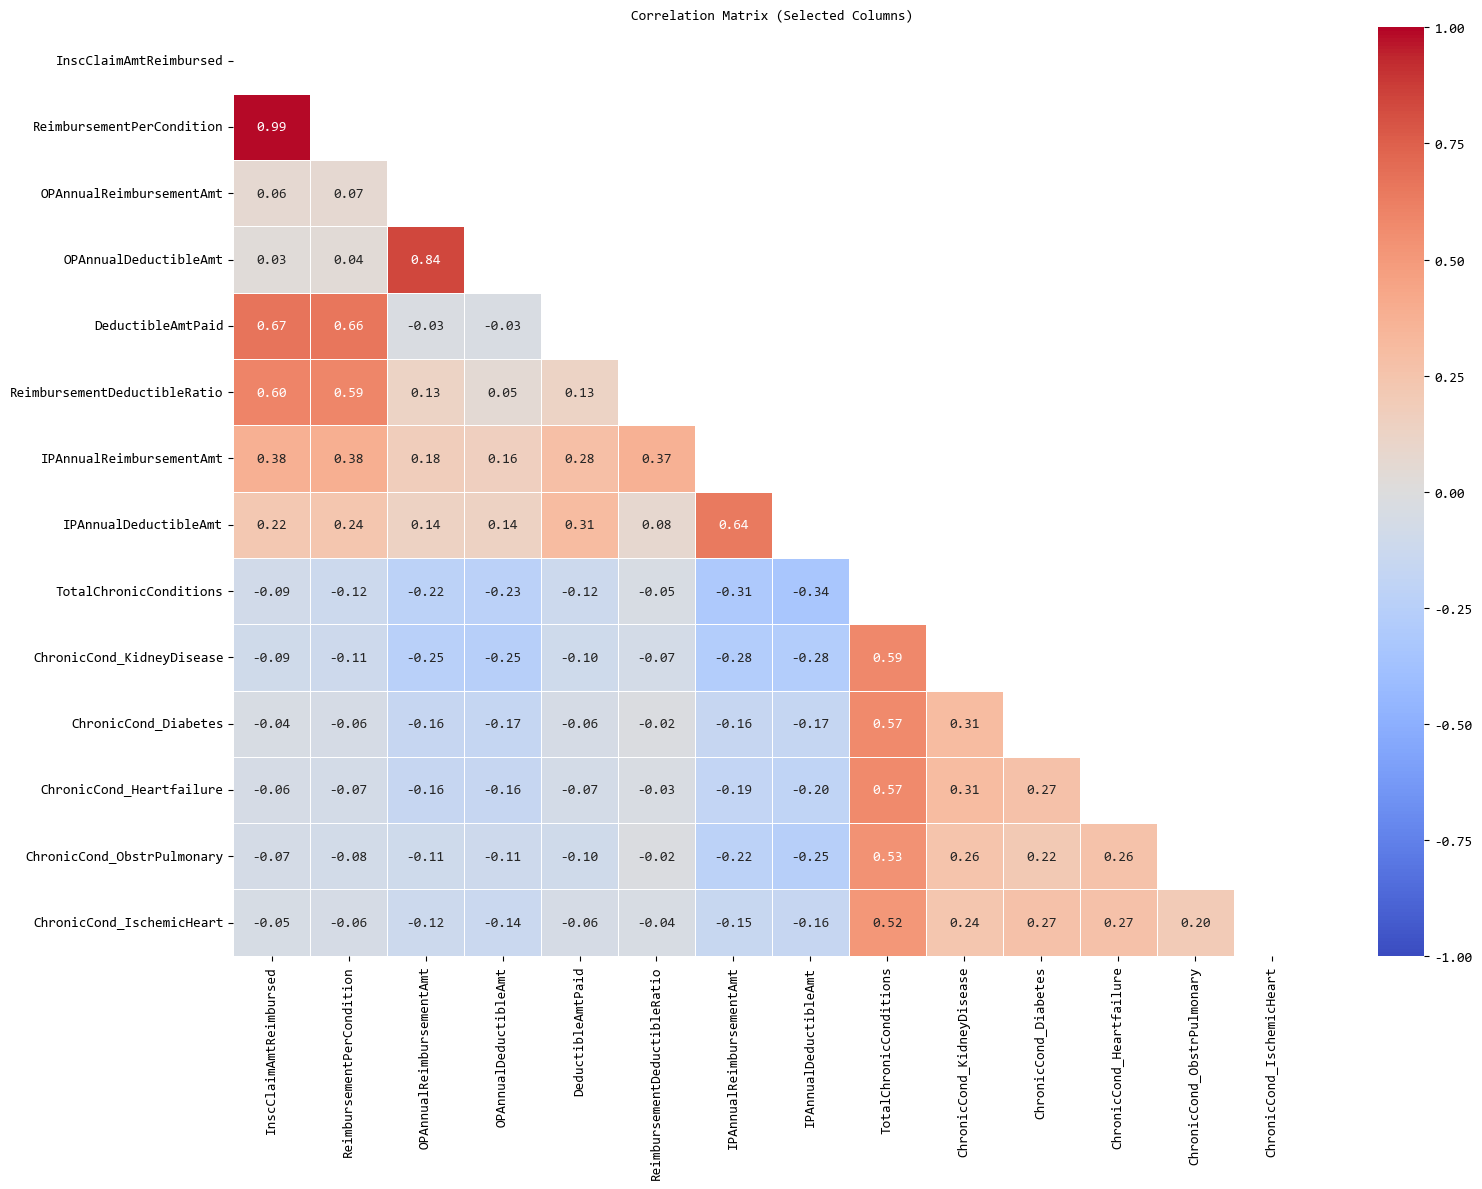

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# columns with correlation >= 0.5
selected_columns = [
    'InscClaimAmtReimbursed', 'ReimbursementPerCondition', 'OPAnnualReimbursementAmt',
    'OPAnnualDeductibleAmt', 'DeductibleAmtPaid', 'ReimbursementDeductibleRatio',
    'IPAnnualReimbursementAmt', 'IPAnnualDeductibleAmt', 'TotalChronicConditions',
    'ChronicCond_KidneyDisease', 'ChronicCond_Diabetes', 'ChronicCond_Heartfailure',
    'ChronicCond_ObstrPulmonary', 'ChronicCond_IschemicHeart'
]

# correlation matrix for the selected columns
corr_matrix_selected = train_combined[selected_columns].corr()

# set up the plot
plt.figure(figsize=(16, 12))

# mask the upper triangle of the correlation matrix
mask = np.triu(np.ones_like(corr_matrix_selected, dtype=bool))

# plot the correlation matrix using a heatmap
sns.heatmap(corr_matrix_selected, annot=True, fmt='.2f', cmap='coolwarm', mask=mask, linewidths=0.5, vmin=-1, vmax=1,
            annot_kws={"fontsize": 10, "fontname": "Consolas"}) 

plt.title('Correlation Matrix (Selected Columns)', fontsize=10, fontname='Consolas')
plt.xticks(fontsize=10, fontname='Consolas')
plt.yticks(fontsize=10, fontname='Consolas')

colorbar = plt.gca().collections[0].colorbar

ticks = colorbar.get_ticks()
colorbar.set_ticks(ticks)  # Reset ticks
colorbar.set_ticklabels([f'{tick:.2f}' for tick in ticks], fontsize=10, fontname='Consolas')

# Show the plot
plt.tight_layout()
plt.show()

In [11]:
from sklearn.preprocessing import LabelEncoder

# Copy datasets
train_encoded = train_combined.copy()
test_encoded = test_combined.copy()

# Categorical columns in both sets
train_cats = set(train_encoded.select_dtypes(include='object').columns)
test_cats = set(test_encoded.select_dtypes(include='object').columns)

# Use only columns present in both sets
common_cats = list(train_cats & test_cats)

# Exclude irrelevant columns that might not contribute to the model
exclude = ['BeneID', 'ClaimID', 'ClaimStartDt', 'ClaimEndDt', 'DOB']
# Include physician-related columns for encoding
physician_columns = ['Provider', 'AttendingPhysician', 'OperatingPhysician', 'OtherPhysician']
columns_to_encode = [col for col in common_cats if col not in exclude] + physician_columns

# Initialize the LabelEncoder
le = LabelEncoder()

# Encode the columns consistently across train and test sets
for col in columns_to_encode:
    combined_data = pd.concat([train_encoded[col], test_encoded[col]], axis=0).astype(str)
    le.fit(combined_data)

    train_encoded[col] = le.transform(train_encoded[col].astype(str))
    test_encoded[col] = le.transform(test_encoded[col].astype(str))

# Drop the excluded columns from both train and test datasets
train_encoded.drop(columns=exclude, inplace=True)
test_encoded.drop(columns=exclude, inplace=True)

# Encode the target variable (y_train and y_test) consistently
target_column = 'PotentialFraud'  

le_target = LabelEncoder()
train_encoded[target_column] = le_target.fit_transform(train_encoded[target_column].astype(str))
test_encoded = test_encoded.drop(columns=['PotentialFraud'], errors='ignore')

In [12]:
# Quick check
train_encoded[columns_to_encode].head()

,ClmDiagnosisCode_2,RenalDiseaseIndicator,ClmDiagnosisCode_1,AttendingPhysician,ClmDiagnosisCode_7,OtherPhysician,OperatingPhysician,ClmDiagnosisCode_4,ClaimType,ClmDiagnosisCode_3,ClmAdmitDiagnosisCode,ClmDiagnosisCode_6,Provider,ClmDiagnosisCode_5,Provider,AttendingPhysician,OperatingPhysician,OtherPhysician
0,1865,0,1067,62037,454,0,0,3143,16274,2402,3203,2161,4347,584,4347,62037,0,0
1,984,0,5444,57467,3168,0,18447,4079,206688,2275,2434,3391,4341,3721,4341,57467,18447,0
2,1095,0,2234,45153,3168,53513,0,1132,69453,2862,904,811,4496,3862,4496,45153,0,53513
3,808,0,4178,42679,399,9093,21175,1023,140021,3414,1704,1237,452,3776,452,42679,21175,9093
4,1132,1,244,51490,1470,0,23282,2229,3909,1186,3156,1518,5127,1426,5127,51490,23282,0


In [13]:
# Quick check
test_encoded[columns_to_encode].head()

,ClmDiagnosisCode_2,RenalDiseaseIndicator,ClmDiagnosisCode_1,AttendingPhysician,ClmDiagnosisCode_7,OtherPhysician,OperatingPhysician,ClmDiagnosisCode_4,ClaimType,ClmDiagnosisCode_3,ClmAdmitDiagnosisCode,ClmDiagnosisCode_6,Provider,ClmDiagnosisCode_5,Provider,AttendingPhysician,OperatingPhysician,OtherPhysician
0,2520,1,5167,51011,1782,0,34437,4267,189937,2061,2274,568,5633,1323,5633,51011,34437,0
1,1910,0,1009,22522,1348,0,34288,2084,15456,2466,2320,1814,3055,1608,3055,22522,34288,0
2,3875,0,3952,24452,2451,0,0,1542,97236,2481,1561,1323,1954,3820,1954,24452,0,0
3,1947,0,8091,97087,1170,0,12917,2284,301363,3966,3455,573,4250,1324,4250,97087,12917,0
4,5068,1,2256,67632,3475,0,0,935,70762,3459,1678,3611,377,3838,377,67632,0,0


In [14]:
# saving the encoded train and test datasets to CSV
train_encoded.to_csv('train_encoded.csv', index=False)
test_encoded.to_csv('test_encoded.csv', index=False)